# Определение возраста покупателей


<h2> Задачи проекта <a class="tocSkip"></h2>
    
    
Необходимо разработать и внедрить систему компьютерного зрения для обработки фотографий покупателей  супермаркета с целью определения возраста. Требуется построить модель, которая по фотографии определит приблизительный возраст человека. 
    
Цели заказчика: 
    
    1. Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей определенной возрастной группы;
    2. Контролировать добросовестность кассиров при продаже алкоголя.
    
Соответственно, для решения поставленной задачи (задачи регрессии) имеет смысл использовать такие метрики качества, как MSE и MAE. Также нам необходимо добиться хорошего показателя этих метрик, так как сильные отклонения могут оказаться критичными.    </div> 

<h2> План работы <a class="tocSkip"></h2>
    
    1. Загрузка исходного датасета 
    2. Построение гистограммы распределенния возрастов покупателей
    3. Оценить, какова общая ориентация фотографий (нужно ли их поворачивать), есть ли черно-белые фотографии, различается ли размер изображений
    4. Разделение данных на фичи и таргет
    5. Использовать сверточную нейронную сеть. 
    6. Использовать необходимые дополнительные слои согласно поставленной задаче
    7. Сделать выводы

## Исследовательский анализ данных

Импортируем необходимые в проекте библиотеки. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

Извлечем данные и посмотрим информацию о датасете.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Посмотрим размер выборки.

In [4]:
labels.shape

(7591, 2)

In [5]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


   Видим, что в исходном датасете 7591 изображение и, соответственно, столько же значений возраста (целевой признак). 
   Чтобы не загружать оперативную память компьютера, будем использовать динамическую загрузку данных, а именно загрузчик данных ImageDataGenerator. Он формирует батчи с изображениями и метками классов.

Используем динамическую загрузку данных.

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)

Found 7591 validated image filenames.


Данные разбиты на батчи по 32 штуки. 

Посомотрим размер батчей. 

In [7]:
features, target = next(train_gen_flow)
print(features.shape)
target.shape

(32, 224, 224, 3)


(32,)

Получили признаки — четырёхмерный тензор, в котором 32 изображения размером 224x224 с тремя цветовыми каналами.

Построим график распределения возраста в выборке.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'распределение')

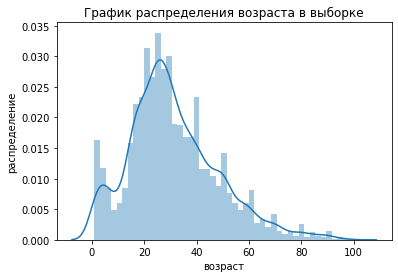

In [8]:
plot = sns.distplot(labels['real_age'])
plot.set_title("График распределения возраста в выборке")
plot.set_xlabel('возраст')
plot.set_ylabel('распределение')

Посмотрим вывод описательных статистик

In [9]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


График распределения похож на распределение Пуассона. Можно заметить два кластера: маленький слева с экстремумом в x=5 и второй большой с точкой максимума при x=29. Можно видеть отдельные пиковые значения возраста. Выбросов как таковых на гистограмме не наблюдается кроме того, что наибольшее значение возраста - 100 лет. 

Ради интереса выведем фото человека возрастом 100 лет =). 

Found 1 validated image filenames.


Text(0.5, 1.0, 'age is 100 ')

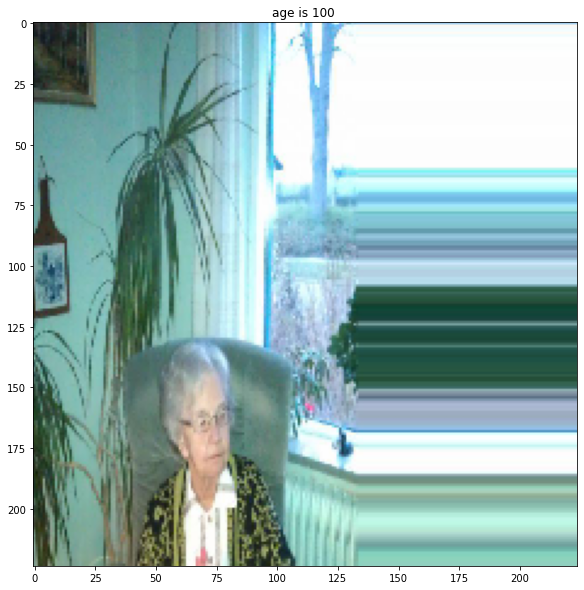

In [13]:
df_temp = labels[(labels['real_age'] == 100)]

datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
    dataframe=df_temp,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)

features, target = next(gen_flow)
fig = plt.figure(figsize=(10, 10))
plt.imshow(features[0])
plt.title('age is {} '.format(target[0]), loc='center')

Напечатаем на экране 15 фотографий

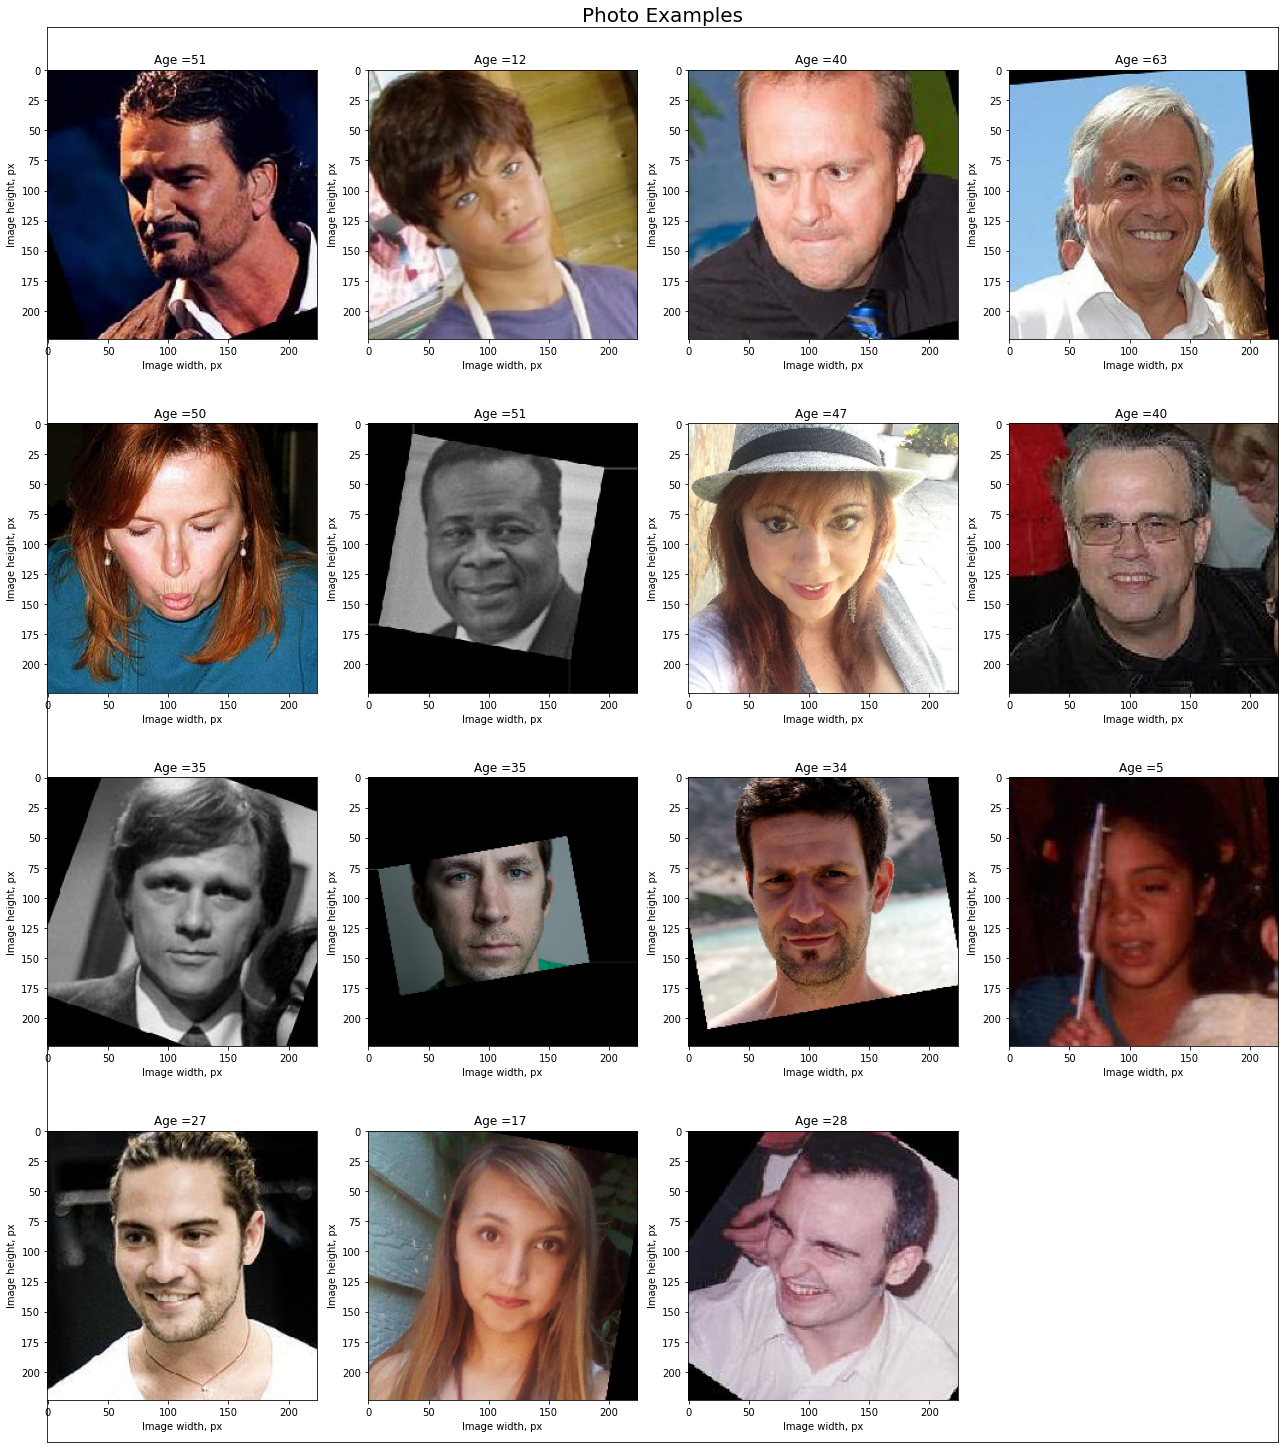

In [14]:
features, target = next(train_gen_flow)

# выводим 15 изображений

fig = plt.figure(figsize=(18, 20))
plt.title('Photo Examples', {'fontsize': 20,
                             'fontweight': 10,
                             'verticalalignment': 'baseline'})
plt.xticks([])
plt.yticks([])
plt.tight_layout()
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.tight_layout()
    plt.title('Age ={} '.format(target[i]), loc='center')
    plt.xlabel('Image width, px')
    plt.ylabel('Image height, px')

### Вывод

У нас происходит динамическая загрузка данных с помощью загрузчика ImageDataGenerator, который формирует батчи (по 32 штуки в нашем случае) с изображениями и метками классов. 
Признаки - это фотографии людей, целевой признак - возраст. Исходя из графика распределения возраста видим, что возраст разный, от детей до пожилых людей. 

Общая ориентация фотографий - вертикальная, переворачивать не требуется, фото цветные, размер уже приведен к единому - 224 на 224 пикселя. В основном лица на фото крупным планом, хотя встречаются фото в полный рост. 

Таким образом, для обучения модели будем использовать архитектуру ResNet50 с весами из ImageNet.

## Обучение модели

Код обучения модели на GPU:

```python

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       horizontal_flip=True, 
                                       rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels, 
                                                       directory=path + 'final_files/', 
                                                       x_col='file_name', 
                                                       y_col='real_age', 
                                                       target_size=(224, 224), 
                                                       batch_size=16, 
                                                       class_mode='raw',
                                                       subset='training', 
                                                       seed=12345)
    
    return train_gen_flow
    
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
                                                        dataframe=labels,
                                                        directory=path + 'final_files/',
                                                        x_col='file_name',
                                                        y_col='real_age',
                                                        target_size=(224, 224),
                                                        batch_size=16,
                                                        class_mode='raw',
                                                        subset='validation',
                                                        seed=12345)
        return test_gen_flow

def create_model(input_shape):    
    backbone = ResNet50(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model
 
```

Результат вывода модели следующий:

```
Train for 356 steps, validate for 119 steps
Epoch 1/20
2022-07-01 12:25:54.162856: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-01 12:25:54.478495: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 64s - loss: 203.5160 - mae: 10.8372 - val_loss: 289.5560 - val_mae: 13.5225
Epoch 2/20
356/356 - 39s - loss: 133.8655 - mae: 8.8534 - val_loss: 204.2193 - val_mae: 10.9429
Epoch 3/20
356/356 - 39s - loss: 112.4073 - mae: 8.0424 - val_loss: 193.5823 - val_mae: 11.5372
Epoch 4/20
356/356 - 39s - loss: 93.8590 - mae: 7.4304 - val_loss: 105.8803 - val_mae: 7.8568
Epoch 5/20
356/356 - 39s - loss: 77.5771 - mae: 6.7885 - val_loss: 107.0683 - val_mae: 7.6542
Epoch 6/20
356/356 - 39s - loss: 65.9903 - mae: 6.2386 - val_loss: 87.2320 - val_mae: 7.0647
Epoch 7/20
356/356 - 39s - loss: 54.9454 - mae: 5.7231 - val_loss: 123.4244 - val_mae: 8.3296
Epoch 8/20
356/356 - 39s - loss: 48.9291 - mae: 5.3294 - val_loss: 136.9255 - val_mae: 8.5436
Epoch 9/20
356/356 - 39s - loss: 42.8704 - mae: 5.0087 - val_loss: 104.9339 - val_mae: 7.8233
Epoch 10/20
356/356 - 39s - loss: 35.8756 - mae: 4.5982 - val_loss: 130.1918 - val_mae: 8.5767
Epoch 11/20
356/356 - 39s - loss: 32.8449 - mae: 4.4433 - val_loss: 97.2031 - val_mae: 7.4199
Epoch 12/20
356/356 - 39s - loss: 26.6803 - mae: 4.0287 - val_loss: 89.9993 - val_mae: 7.0165
Epoch 13/20
356/356 - 39s - loss: 22.8113 - mae: 3.6880 - val_loss: 82.1507 - val_mae: 6.8682
Epoch 14/20
356/356 - 38s - loss: 20.3556 - mae: 3.4852 - val_loss: 79.4632 - val_mae: 6.6373
Epoch 15/20
356/356 - 38s - loss: 22.1860 - mae: 3.6272 - val_loss: 102.7942 - val_mae: 7.4596
Epoch 16/20
356/356 - 39s - loss: 21.8571 - mae: 3.6027 - val_loss: 87.8098 - val_mae: 7.0443
Epoch 17/20
356/356 - 39s - loss: 20.1174 - mae: 3.4598 - val_loss: 92.0808 - val_mae: 7.2192
Epoch 18/20
356/356 - 39s - loss: 20.2379 - mae: 3.4522 - val_loss: 82.0822 - val_mae: 6.7849
Epoch 19/20
356/356 - 39s - loss: 18.4940 - mae: 3.2853 - val_loss: 80.4993 - val_mae: 6.7156
Epoch 20/20
356/356 - 38s - loss: 17.8365 - mae: 3.2164 - val_loss: 75.4494 - val_mae: 6.4919
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 75.4494 - mae: 6.4919
Test MAE: 6.4919

```

Получили Среднюю абсолютную ошибку 6.49. Это вполне неплохо.

## Анализ обученной модели

1. В качестве метрики качества использовалась MAE, так как она менее чувствительна к выбросам, нежели MSE. 
2. Результат MAE = 6.49 - неплохой.
3. Во избежание переобучения, была «заморожена» часть сети: некоторые слои были оставлены с весами из ImageNet, они не будут обучаться градиентным спуском. 
4. Помимо архитектуры ResNet в Keras использовался GlobalAveragePooling2D — пулинг с окном во весь тензор, и один полносвязный слой Dense с одним нейроном на выходе для получения модели.
5. Так как мы решаем задачу регрессии, то на выходе как раз таки нужен всего один нейрон.
6. Функция активации использовалась ReLU. Тк не могут быть отрицательные значения возраста.
7. Для автоматического подбора шага градиентного спуска, применили алгоритм Adam.

На мой взгляд, в целом полученная модель решит первую поставленную задачу хорошо - у нас не такая большая погрешность, и можно правильной определить предпочтения покупателей в разных возрастных группах. Что касается второй задачи, то тут, мне кажется, метрику качества еще надо улучшать! 